WAKE hackathon
===
- In this notebook we query SDSS for WD spectra based on [Kepler et al., (2021)](https://arxiv.org/abs/2108.10915)
- We then apply PCA to identify the most prominent 'eigen-spectra' for the dataset, to build a low-dimensional basis suitable for classification, and as a bonus denoise the input spectra.
- As a final bonus we apply t-SNE to the full spectral dataset to generate a label-agnostic clustering.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from urllib.error import HTTPError, URLError

from astroML.datasets import fetch_sdss_spectrum

In [2]:
# Table 2 of Kepler+21
path_to_downloaded_table = "~/Downloads/Table2.txt"
wd_df = pd.read_fwf(path_to_downloaded_table, skiprows=1)

interesting_classes = ['DA:H', 'DAH', 'DAH:']
mask = [row.ty in interesting_classes for _, row in wd_df.iterrows()]

In [4]:
smoothing_length = 5
norm_wavelength = 5500

spectrum_list = []

df_subset = wd_df.iloc[mask]

common_wavelength_range = np.linspace(3780, 8000, 4096)

for _, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
    p, m, f = row['#P-M-F'].split("-")

    try:
        spec = fetch_sdss_spectrum(plate=int(p), mjd=int(m), fiber=int(f))
    except (HTTPError, URLError) as e:
        # just skip this
        print(e)
        continue

    # normalise to common wavelength rang
    results_dict = {
        "name": row['#P-M-F'],
        "type": row['ty'],
        "wav": common_wavelength_range,
    }

    # set up a smoothing kernel to suppress noise
    smoothing_kernel = np.ones(smoothing_length) / smoothing_length
    smoothed_flux = np.convolve(spec.spectrum, smoothing_kernel, mode='same')

    results_dict["flux"] = np.interp(common_wavelength_range, spec.wavelength(), smoothed_flux)

    norm_point = np.interp(norm_wavelength, results_dict['wav'], results_dict['flux'])
    results_dict['normflux'] = results_dict['flux'] / norm_point

    spectrum_list.append(results_dict)

results_df = pd.DataFrame(spectrum_list)

wd_class, number = np.unique(results_df.type.values, return_counts=True)
for wd_cl, n in zip(wd_class, number):
    print(f"{wd_cl}: {n}")

  0%|          | 0/475 [00:00<?, ?it/s]

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 4

In [5]:
from sklearn.decomposition import PCA

# build a stack of spectra suitable to feed into dimensionality reduction.
spectrum_stack = np.stack([r for r in results_df.normflux.values])
pca_reduction = PCA().fit(spectrum_stack)

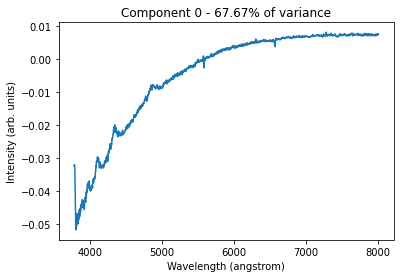

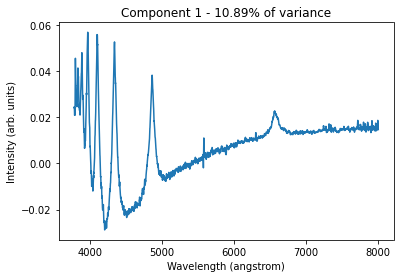

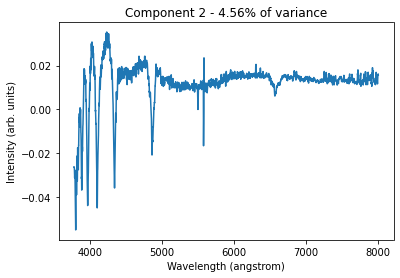

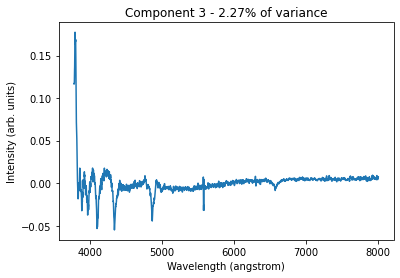

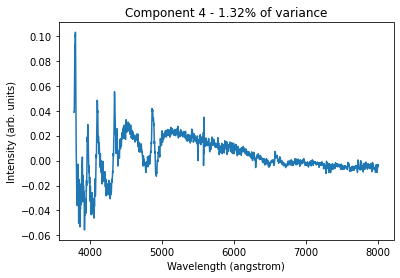

In [6]:
for component_number, cmpt in enumerate(pca_reduction.components_[:5]):
    plt.plot(common_wavelength_range, cmpt)
    plt.xlabel("Wavelength (angstrom)")
    plt.ylabel("Intensity (arb. units)")
    plt.title(f"Component {component_number} - {100*pca_reduction.explained_variance_ratio_[component_number]:.2f}% of variance")
    plt.show()

Text(0, 0.5, 'Cumulative fraction of variance explained')

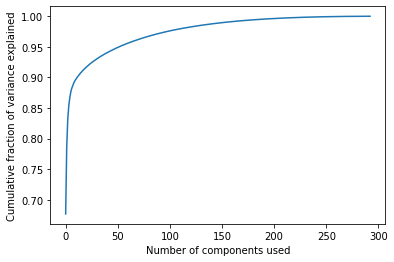

In [7]:
plt.plot(np.cumsum(pca_reduction.explained_variance_ratio_))
plt.xlabel("Number of components used")
plt.ylabel("Cumulative fraction of variance explained")

In [8]:
pca_reduction = PCA(n_components=20)
pca_coeffs = pca_reduction.fit_transform(spectrum_stack)
reconstructed_spectra = pca_reduction.inverse_transform(pca_coeffs)

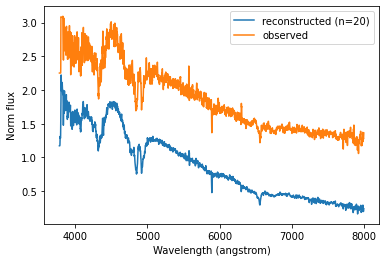

In [9]:
plt.plot(common_wavelength_range, reconstructed_spectra[56], label=f'reconstructed (n={pca_reduction.n_components_})')
plt.plot(common_wavelength_range, results_df.normflux[56] + 1, label='observed')
plt.xlabel("Wavelength (angstrom)")
plt.ylabel("Norm flux")
plt.legend()

In [10]:
from sklearn.manifold import TSNE

In [11]:
tsne_reduced = TSNE(n_components=2, verbose=1, n_jobs=4, init='pca', learning_rate='auto').fit_transform(spectrum_stack)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 293 samples in 0.002s...
[t-SNE] Computed neighbors for 293 samples in 0.339s...
[t-SNE] Computed conditional probabilities for sample 293 / 293
[t-SNE] Mean sigma: 4.074488


/home/thomas/teaching_courses/WAKE_workshops/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.277901
[t-SNE] KL divergence after 900 iterations: 0.529221


Text(0, 0.5, 'Latent vector 1')

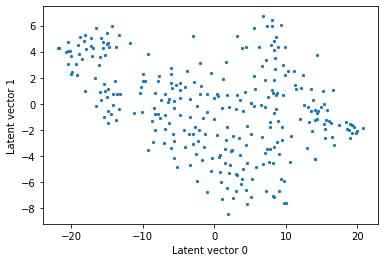

In [12]:
plt.scatter(*tsne_reduced.T, s=5)
plt.xlabel("Latent vector 0")
plt.ylabel("Latent vector 1")

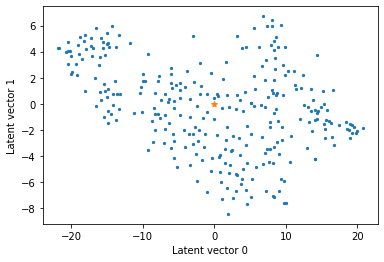

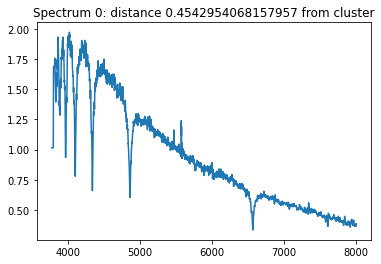

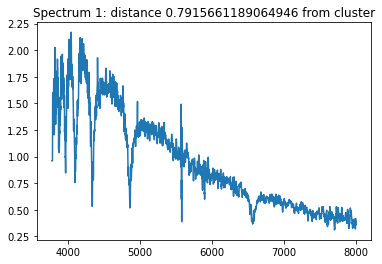

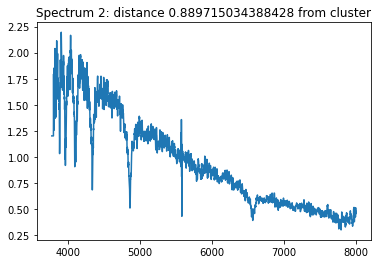

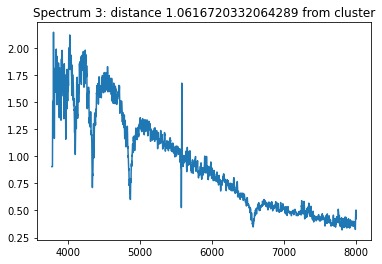

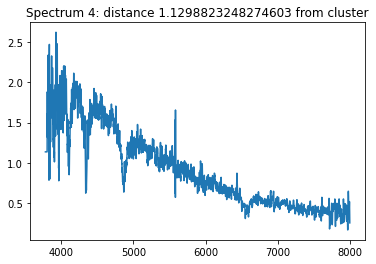

In [13]:
cluster_point = np.array([0, 0])

pairwise_distances = np.linalg.norm(tsne_reduced - cluster_point[np.newaxis, :], axis=1)
distance_ordering = pairwise_distances.argsort()

plt.scatter(*tsne_reduced.T, s=5)
plt.xlabel("Latent vector 0")
plt.ylabel("Latent vector 1")
plt.scatter(*cluster_point, marker='*')
plt.show()

for n_closest, dist_idx in enumerate(distance_ordering[:5]):
    spec = results_df.iloc[dist_idx]
    plt.plot(spec.wav, spec.normflux)
    plt.title(f"Spectrum {n_closest}: distance {pairwise_distances[dist_idx]} from cluster")
    plt.show()